In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, shapiro, norm
import scipy.stats as stats
import math
#import ace_tools as tools


## Load US CPI Timeseries Data

In [ ]:
df = pd.read_csv("../data/processed/USA_CPI_Processed_2018_2019.csv")

In [23]:
print(df)

    Airline fares  Alcoholic beverages  Alcoholic beverages at home  \
0        280.6240             246.1560                     204.1220   
1        282.5265             245.9850                     203.5960   
2        283.8680             246.4585                     203.9110   
3        283.8275             246.9445                     204.6325   
4        279.0975             246.6935                     203.8635   
5        276.8460             246.6740                     203.3830   
6        275.0975             247.1500                     203.8485   
7        270.9235             247.3790                     204.1585   
8        268.9300             248.0480                     204.9505   
9        268.3105             248.3805                     205.3110   
10       265.9975             248.9055                     205.8855   
11       266.8740             249.0405                     205.8250   
12       266.5340             249.1380                     205.2960   
13    

In [24]:
df["REF_DATE"] = pd.to_datetime(df["REF_DATE"])

In [25]:
#Unpivot dataframe
df = df.melt(id_vars=['REF_DATE'], var_name='Variable', value_name='Value')
df = df.rename(columns={"Variable": "Product_Service", "Value": "VALUE"})

## Add Product Category to the CPI Timeseries Dataframe

In [ ]:
# Add category to the dataframe
df_categories = pd.read_csv("../data/processed/US_Categorized_Products_and_Services_NEW.csv")

# Merging df with df_categories on 'Product_Service'
df = df_categories.merge(df, on='Product_Service', how='inner')

# Reordering columns
df = df[['Category', 'Product_Service', 'REF_DATE', 'VALUE']]

# Display the new DataFrame
print(df)


            Category                                    Product_Service  \
0     Transportation                                      Airline fares   
1     Transportation                                      Airline fares   
2     Transportation                                      Airline fares   
3     Transportation                                      Airline fares   
4     Transportation                                      Airline fares   
...              ...                                                ...   
8023   Uncategorized  Women's underwear, nightwear, swimwear, and ac...   
8024   Uncategorized  Women's underwear, nightwear, swimwear, and ac...   
8025   Uncategorized  Women's underwear, nightwear, swimwear, and ac...   
8026   Uncategorized  Women's underwear, nightwear, swimwear, and ac...   
8027   Uncategorized  Women's underwear, nightwear, swimwear, and ac...   

       REF_DATE     VALUE  
0    2017-01-01  280.6240  
1    2017-02-01  282.5265  
2    2017-03-01

## Run Anderson-Darling test at the Category level

In [28]:
# Function to test normality using Anderson-Darling test
def test_normality(series):
    result = anderson(series.dropna(), dist='norm')
    return result.statistic, result.critical_values, result.significance_level

# Group by Category and apply normality test
results = []
for category, group in df.groupby("Category"):
    stat, crit_values, sig_levels = test_normality(group["VALUE"])
    
    # Find the significance level where statistic < critical value
    normality = any(stat < cv for cv in crit_values)
    
    results.append({
        "Category": category,
        "Test_Statistic": stat,
        "Normal_Anderson_Darling?": normality
    })

# Convert to DataFrame and display
results_df_AD_cat = pd.DataFrame(results)
#tools.display_dataframe_to_user(name="Normality Test Results", dataframe=results_df_AD_cat)
print(results_df_AD_cat)

                          Category  Test_Statistic  Normal_Anderson_Darling?
0                Alcohol & Tobacco        5.907749                     False
1           Appliances & Equipment       14.706181                     False
2              Clothing & Footwear       72.534794                     False
3                    Communication       14.365321                     False
4              Education & Reading       13.802445                     False
5                           Energy       18.544466                     False
6           Furniture & Home Decor       11.363981                     False
7                        Groceries       15.836486                     False
8           Health & Personal Care       17.375901                     False
9               Household Supplies       10.531515                     False
10             Housing & Utilities       26.376875                     False
11  Housing, Rent, Tax & Insurance        2.828237                     False

In [29]:
# Function to test normality using Shapiro-Wilk test
def test_normality(series):
    if len(series) < 3:  # Shapiro-Wilk requires at least 3 data points
        return np.nan, np.nan
    stat, p_value = shapiro(series.dropna())
    return stat, p_value

# Group by Product_Service and apply normality test
results = []
for category, group in df.groupby("Category"):
    stat, p_value = test_normality(group["VALUE"])
    
    # A p-value > 0.05 means we fail to reject normality (data is likely normal)
    normality = p_value > 0.05

    results.append({
        "Category": category,
        "Test_Statistic": stat,
        "P_Value": p_value,
        "Normal_Shapiro_Wilk?": normality
    })

# Convert results to DataFrame and display
results_df_SW_cat = pd.DataFrame(results)

# Display the results
#tools.display_dataframe_to_user(name="Shapiro-Wilk Normality Test Results", dataframe=results_df_SW)
print(results_df_SW_cat)

                          Category  Test_Statistic       P_Value  \
0                Alcohol & Tobacco        0.898221  8.936159e-10   
1           Appliances & Equipment        0.886974  1.750619e-16   
2              Clothing & Footwear        0.708404  3.069364e-31   
3                    Communication        0.815571  2.830410e-15   
4              Education & Reading        0.855872  1.348806e-14   
5                           Energy        0.937753  3.115545e-17   
6           Furniture & Home Decor        0.670655  1.997117e-11   
7                        Groceries        0.960101  3.582440e-19   
8           Health & Personal Care        0.863745  3.153588e-17   
9               Household Supplies        0.692826  5.501108e-11   
10             Housing & Utilities        0.823162  1.818443e-21   
11  Housing, Rent, Tax & Insurance        0.806289  2.176630e-05   
12      Recreation & Entertainment        0.893886  3.010205e-14   
13                        Services        0.9537

In [30]:
# Merging result of both tests (Shapiro-Wilk and Andersen-Darling) in one dataframe so that results could be compared side by side
results_df_SW_AD_cat = results_df_SW_cat.merge(results_df_AD_cat, on='Category', how='inner')

# Reordering columns
results_df_SW_AD_cat = results_df_SW_AD_cat[['Category', 'Normal_Shapiro_Wilk?', 'Normal_Anderson_Darling?']]

# Display the new DataFrame
print(results_df_SW_AD_cat)

                          Category  Normal_Shapiro_Wilk?  \
0                Alcohol & Tobacco                 False   
1           Appliances & Equipment                 False   
2              Clothing & Footwear                 False   
3                    Communication                 False   
4              Education & Reading                 False   
5                           Energy                 False   
6           Furniture & Home Decor                 False   
7                        Groceries                 False   
8           Health & Personal Care                 False   
9               Household Supplies                 False   
10             Housing & Utilities                 False   
11  Housing, Rent, Tax & Insurance                 False   
12      Recreation & Entertainment                 False   
13                        Services                 False   
14                  Transportation                 False   
15                   Uncategorized      

## Plot Normalization distribution curve for all categories

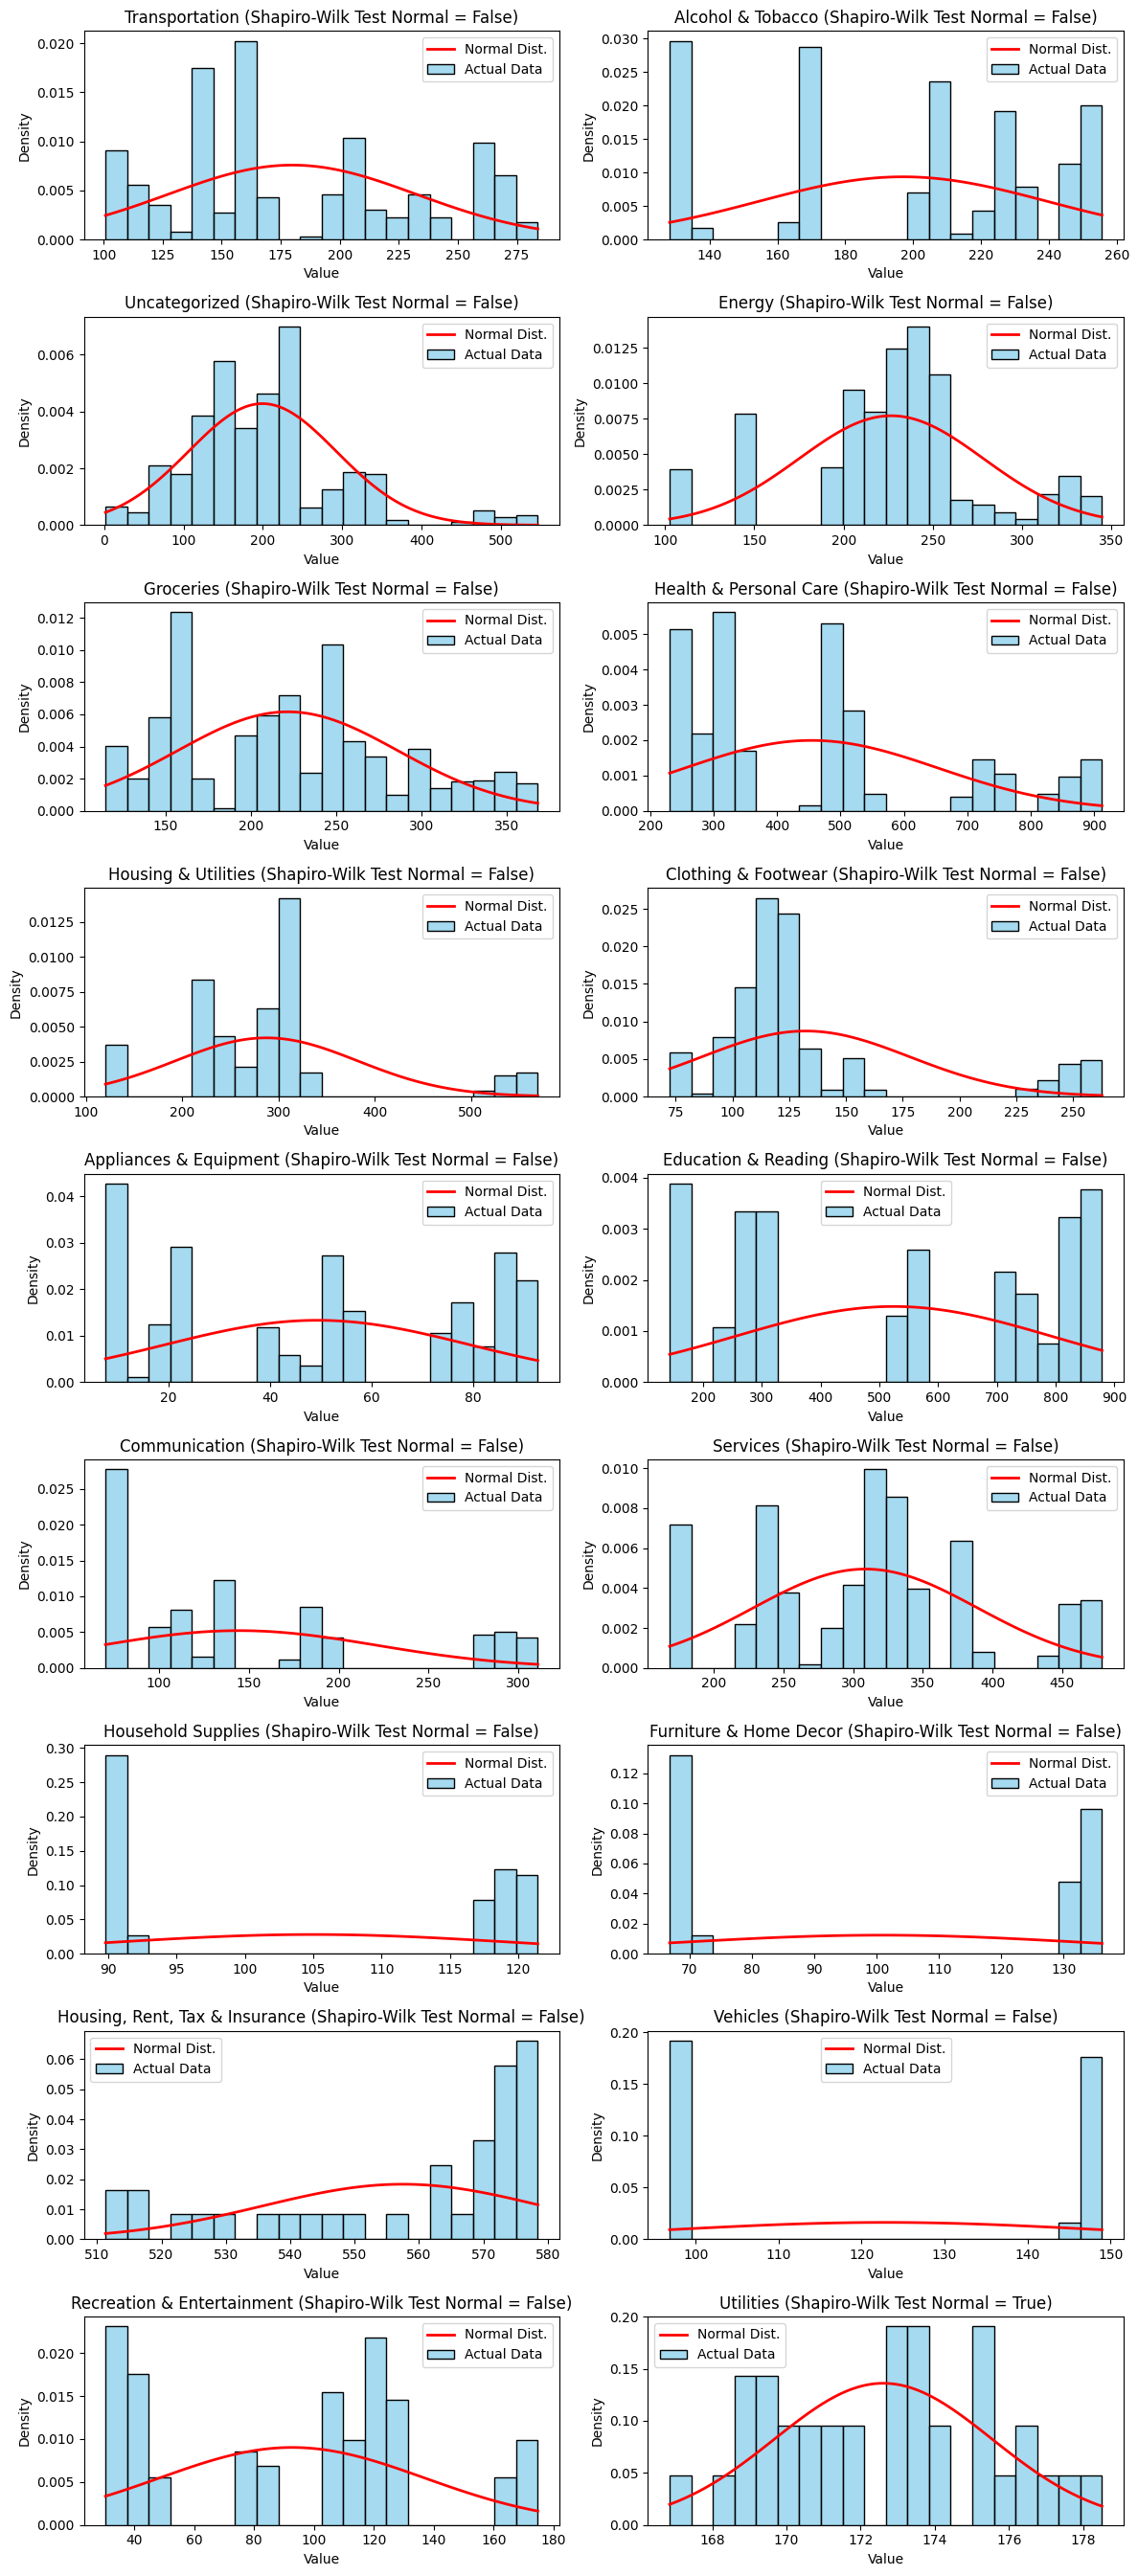

In [31]:
#Plot normal distributions for all Categories

# Extract the Category values into a list
timeseries_to_plot = df["Category"].unique().tolist()

# Number of rows and columns for subplots
num_plots = len(timeseries_to_plot)
num_cols = 2  # One plot per row
num_rows = (num_plots + 1) // num_cols  # Calculate needed rows

# Set up the figure with a reduced size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each time series ID and plot
for i, ts_id in enumerate(timeseries_to_plot):
    ax = axes[i]
    
    # Filter data for the current time series ID
    ts_data = df[df["Category"] == ts_id]["VALUE"].dropna()
    
    # Skip if no data available
    if ts_data.empty:
        ax.set_visible(False)  # Hide empty plots
        continue
    
    # Calculate mean and standard deviation
    mu, sigma = np.mean(ts_data), np.std(ts_data)

    # Generate x values for normal distribution curve
    x = np.linspace(min(ts_data), max(ts_data), 100)
    pdf = norm.pdf(x, mu, sigma)

    # Plot histogram
    sns.histplot(ts_data, bins=20, kde=False, stat="density", color='skyblue', label="Actual Data", ax=ax)

    # Plot normal distribution curve
    ax.plot(x, pdf, color='red', linewidth=2, label="Normal Dist.")

    # Titles and labels
    SW_test_result = results_df_SW_AD_cat.loc[results_df_SW_AD_cat["Category"] == ts_id, "Normal_Shapiro_Wilk?"].values[0]
    ax.set_title(f"{ts_id} (Shapiro-Wilk Test Normal = {SW_test_result})")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

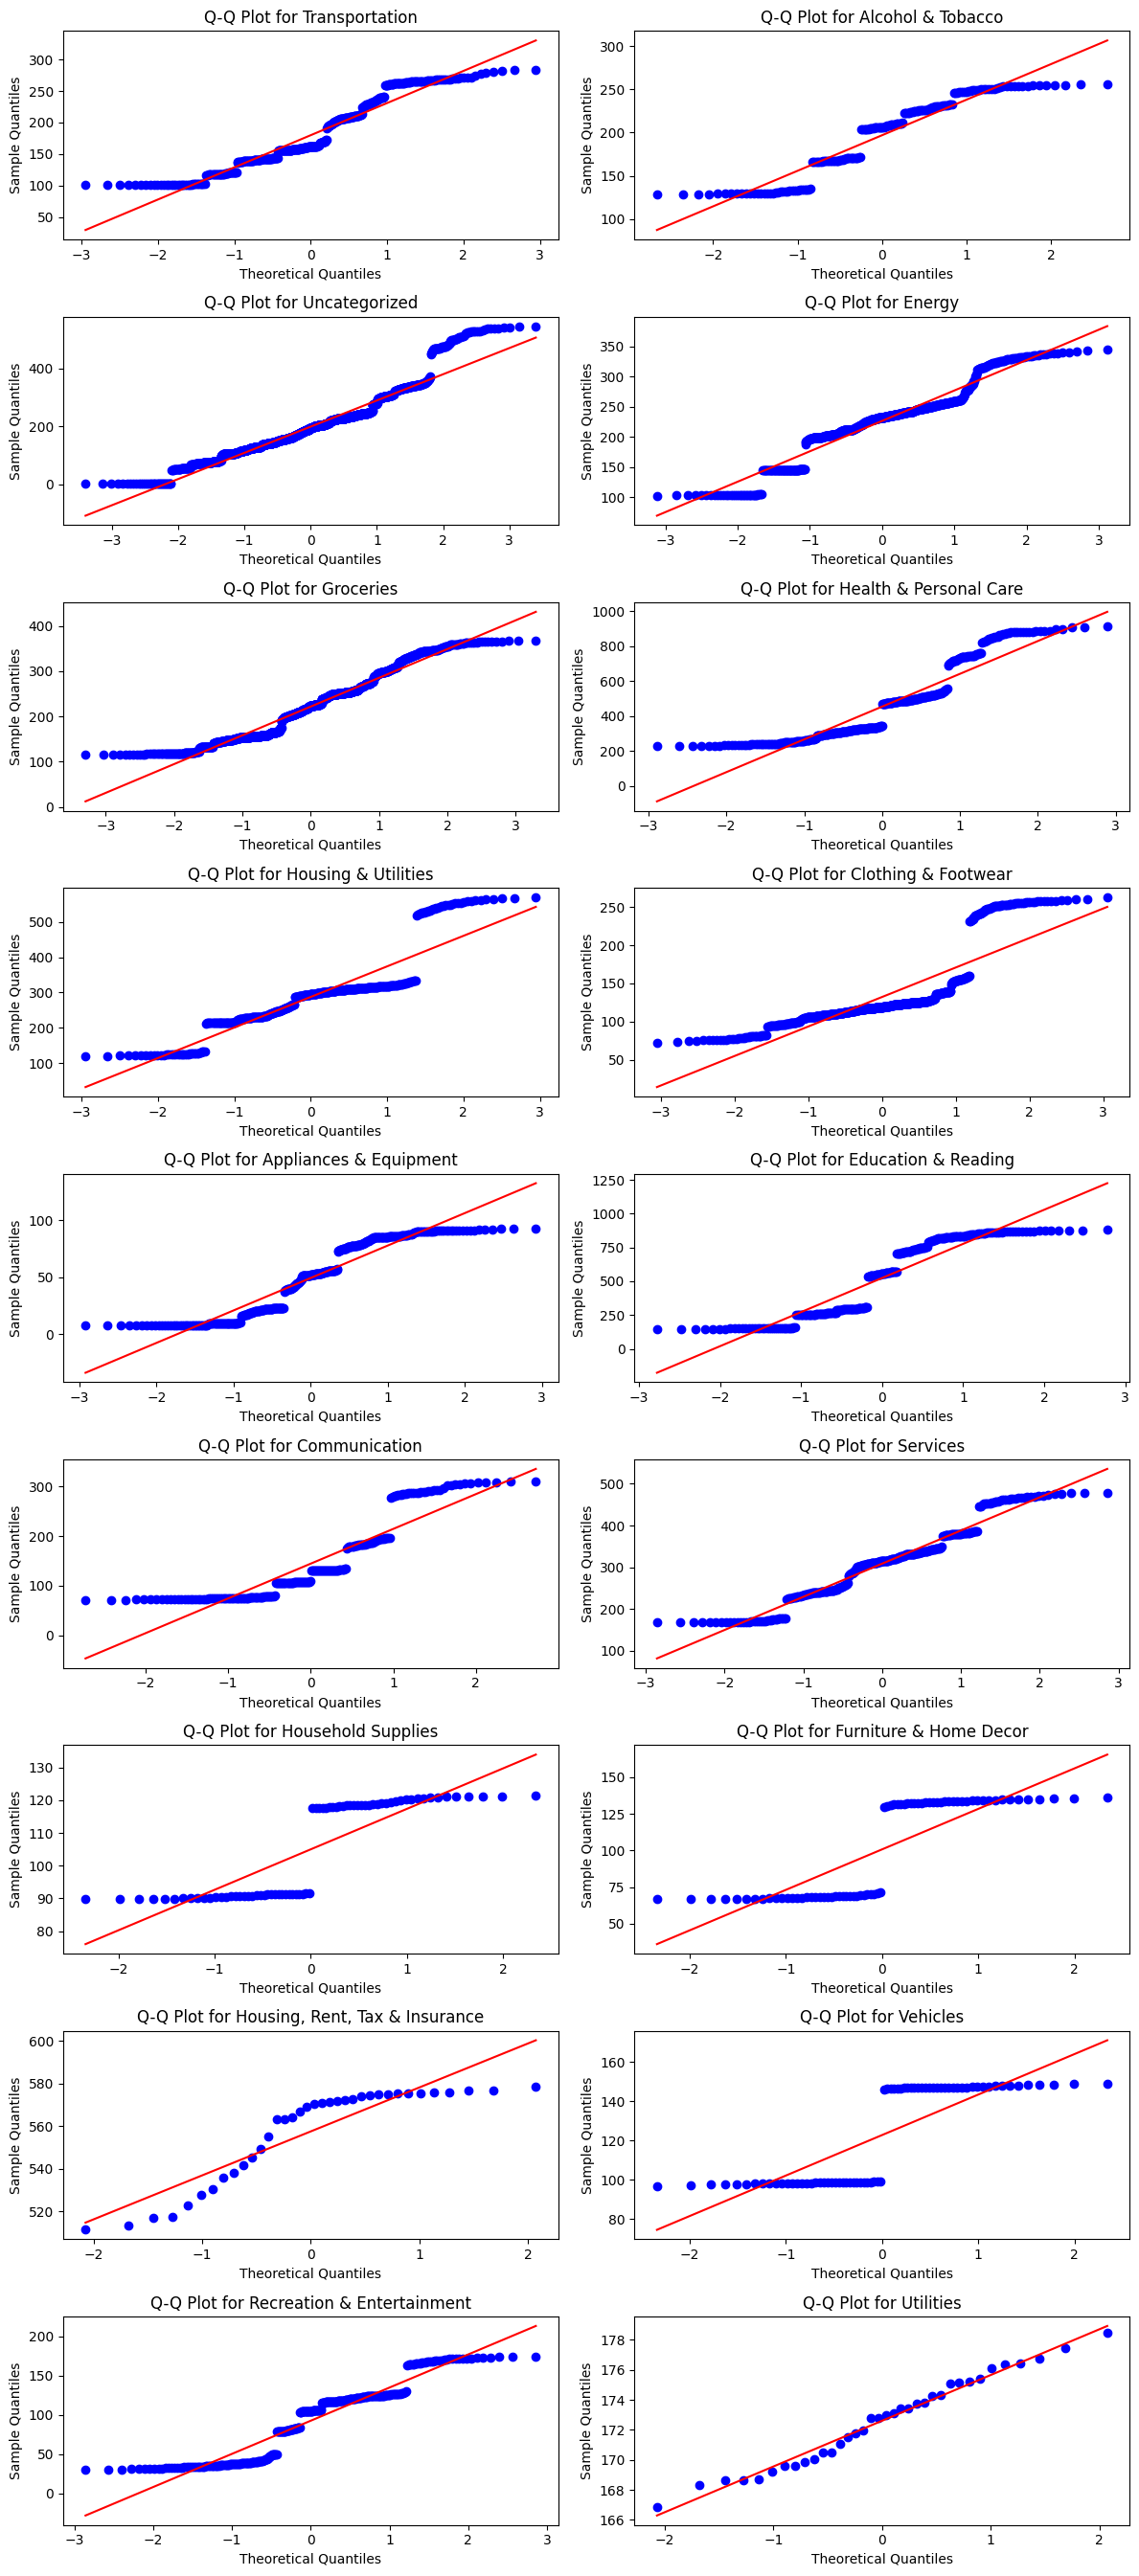

In [32]:
# Number of rows and columns for subplots
num_plots = len(timeseries_to_plot)
num_cols = 2  # Two plots per row
num_rows = (num_plots + 1) // num_cols  # Calculate needed rows

# Set up the figure with reduced height
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))  # Adjust height
axes = axes.flatten()  # Flatten axes for easy iteration

# Loop through each time series ID and plot Q-Q plot
for i, ts_id in enumerate(timeseries_to_plot):
    ax = axes[i]
    
    # Filter data for the current time series ID
    ts_data = df[df["Category"] == ts_id]["VALUE"].dropna()
    
    # Skip if no data available
    if ts_data.empty:
        ax.set_visible(False)  # Hide empty plots
        continue
    
    # Q-Q Plot
    stats.probplot(ts_data, dist="norm", plot=ax)
    
    # Titles and labels
    ax.set_title(f"Q-Q Plot for {ts_id}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Run Anderson-Darling test at the Individual Product level for all Products

In [33]:
# Function to test normality using Anderson-Darling test
def test_normality(series):
    result = anderson(series.dropna(), dist='norm')
    return result.statistic, result.critical_values, result.significance_level

# Group by Product_Service and apply normality test
results = []
for product, group in df.groupby("Product_Service"):
    stat, crit_values, sig_levels = test_normality(group["VALUE"])
    
    # Find the significance level where statistic < critical value
    normality = any(stat < cv for cv in crit_values)
    
    results.append({
        "Product_Service": product,
        "Test_Statistic": stat,
        "Normal_Anderson_Darling?": normality
    })

# Convert to DataFrame and display
results_df_AD = pd.DataFrame(results)
#tools.display_dataframe_to_user(name="Normality Test Results", dataframe=results_df_AD)
print(results_df_AD)

                                       Product_Service  Test_Statistic  \
0                                        Airline fares        1.270668   
1                                  Alcoholic beverages        0.804018   
2                          Alcoholic beverages at home        0.853013   
3                                            All items        0.686085   
4                                All items less energy        0.499958   
..                                                 ...             ...   
218                                    Women's dresses        0.299890   
219                                   Women's footwear        0.425926   
220                                  Women's outerwear        0.250515   
221                        Women's suits and separates        0.619847   
222  Women's underwear, nightwear, swimwear, and ac...        0.431581   

     Normal_Anderson_Darling?  
0                       False  
1                        True  
2              

In [34]:
# Function to test normality using Shapiro-Wilk test
def test_normality(series):
    if len(series) < 3:  # Shapiro-Wilk requires at least 3 data points
        return np.nan, np.nan
    stat, p_value = shapiro(series.dropna())
    return stat, p_value

# Group by Product_Service and apply normality test
results = []
for product, group in df.groupby("Product_Service"):
    stat, p_value = test_normality(group["VALUE"])
    
    # A p-value > 0.05 means we fail to reject normality (data is likely normal)
    normality = p_value > 0.05

    results.append({
        "Product_Service": product,
        "Test_Statistic": stat,
        "P_Value": p_value,
        "Normal_Shapiro_Wilk?": normality
    })

# Convert results to DataFrame and display
results_df_SW = pd.DataFrame(results)

# Display the results
#tools.display_dataframe_to_user(name="Shapiro-Wilk Normality Test Results", dataframe=results_df_SW)
print(results_df_SW)

                                       Product_Service  Test_Statistic  \
0                                        Airline fares        0.909340   
1                                  Alcoholic beverages        0.925724   
2                          Alcoholic beverages at home        0.929852   
3                                            All items        0.932509   
4                                All items less energy        0.944671   
..                                                 ...             ...   
218                                    Women's dresses        0.968867   
219                                   Women's footwear        0.961218   
220                                  Women's outerwear        0.973989   
221                        Women's suits and separates        0.952517   
222  Women's underwear, nightwear, swimwear, and ac...        0.969631   

      P_Value  Normal_Shapiro_Wilk?  
0    0.006205                 False  
1    0.018604                 False

In [35]:
# Merging result of both tests (Shapiro-Wilk and Andersen-Darling) in one dataframe so that results could be compared side by side
results_df_SW_AD = results_df_SW.merge(results_df_AD, on='Product_Service', how='inner')

# Reordering columns
results_df_SW_AD = results_df_SW_AD[['Product_Service', 'Normal_Shapiro_Wilk?', 'Normal_Anderson_Darling?']]

# Display the new DataFrame
print(results_df_SW_AD)


                                       Product_Service  Normal_Shapiro_Wilk?  \
0                                        Airline fares                 False   
1                                  Alcoholic beverages                 False   
2                          Alcoholic beverages at home                 False   
3                                            All items                 False   
4                                All items less energy                  True   
..                                                 ...                   ...   
218                                    Women's dresses                  True   
219                                   Women's footwear                  True   
220                                  Women's outerwear                  True   
221                        Women's suits and separates                  True   
222  Women's underwear, nightwear, swimwear, and ac...                  True   

     Normal_Anderson_Darling?  
0      

## Filter the records for Products that follow normal distribution 


In [36]:
#Filter the records for Products that follow normal distribution 
filtered_df_normal = results_df_SW_AD[(results_df_SW_AD["Normal_Shapiro_Wilk?"] == True)]


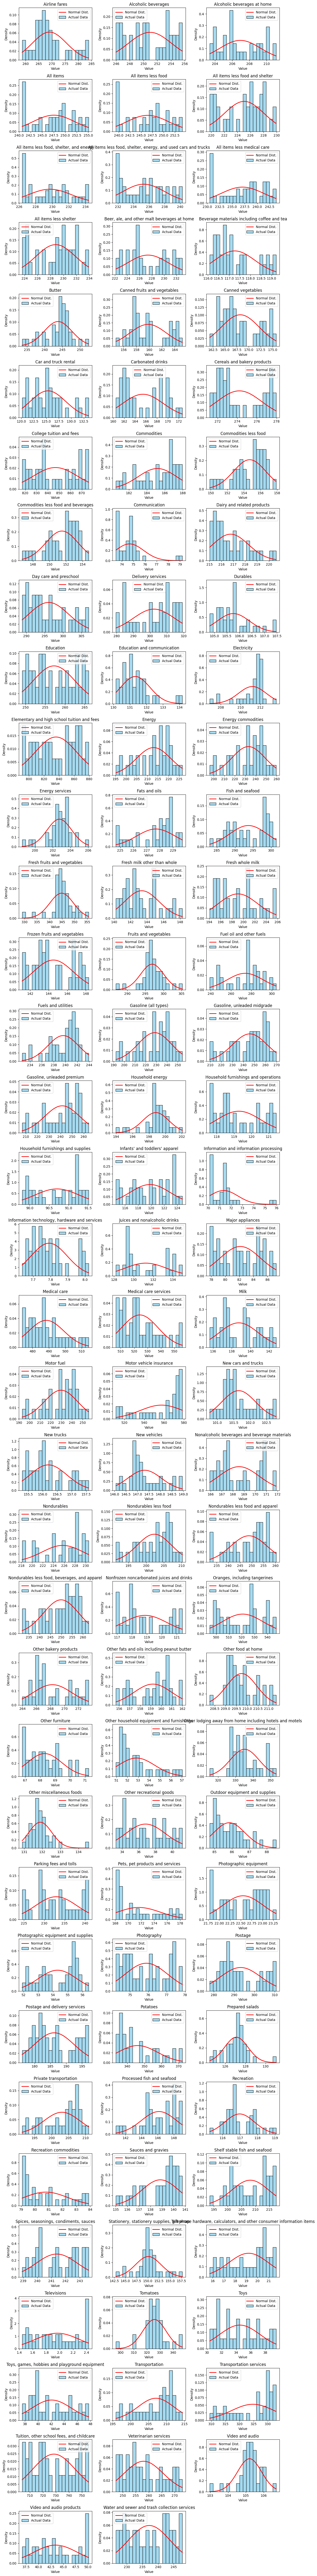

In [37]:
""" Plot normal distributions for Products where Shapiro-Wilk test returns Normal as False
indicating that the data diesn't follow normal distribution """

# Filter the DataFrame for rows where both tests say that the data doesn't follow normal distribution (False)

filtered_df_not_normal = results_df_SW_AD[(results_df_SW_AD["Normal_Shapiro_Wilk?"] == False)]

# Extract the Product_Service values into a list
non_normal_timeseries = filtered_df_not_normal["Product_Service"].tolist()

# Number of rows and columns for subplots
num_plots = len(non_normal_timeseries)
num_cols = 3  # Three plots per row
num_rows = math.ceil(num_plots/num_cols)  # Calculate needed rows

# Set up the figure with a reduced size
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each time series ID and plot
for i, ts_id in enumerate(non_normal_timeseries):
    ax = axes[i]
    
    # Filter data for the current time series ID
    ts_data = df[df["Product_Service"] == ts_id]["VALUE"].dropna()
    
    # Skip if no data available
    if ts_data.empty:
        ax.set_visible(False)  # Hide empty plots
        continue
    
    # Calculate mean and standard deviation
    mu, sigma = np.mean(ts_data), np.std(ts_data)

    # Generate x values for normal distribution curve
    x = np.linspace(min(ts_data), max(ts_data), 100)
    pdf = norm.pdf(x, mu, sigma)

    # Plot histogram
    sns.histplot(ts_data, bins=20, kde=False, stat="density", color='skyblue', label="Actual Data", ax=ax)

    # Plot normal distribution curve
    ax.plot(x, pdf, color='red', linewidth=2, label="Normal Dist.")

    # Titles and labels
    ax.set_title(f"{ts_id}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Rechecking the normality for Category Groceries to confirm normality as the visual distribution looks symmetrical but both the tests  (Shapiro-Wilk and Andersen-Darling) indicate it is not normal

In [38]:
df_can_groceries = df.loc[df["Category"] == "Groceries"]

In [39]:
print(df_can_groceries)

       Category                Product_Service   REF_DATE     VALUE
180   Groceries            All items less food 2017-01-01  239.4240
181   Groceries            All items less food 2017-02-01  239.7155
182   Groceries            All items less food 2017-03-01  239.4690
183   Groceries            All items less food 2017-04-01  239.7180
184   Groceries            All items less food 2017-05-01  239.3875
...         ...                            ...        ...       ...
6871  Groceries  Shelf stable fish and seafood 2019-08-01  213.8580
6872  Groceries  Shelf stable fish and seafood 2019-09-01  217.4400
6873  Groceries  Shelf stable fish and seafood 2019-10-01  216.0810
6874  Groceries  Shelf stable fish and seafood 2019-11-01  213.0850
6875  Groceries  Shelf stable fish and seafood 2019-12-01  213.7180

[1404 rows x 4 columns]


In [40]:
stat, p_value = test_normality(df_can_groceries["VALUE"])

In [41]:
# A p-value > 0.05 means we fail to reject normality (data is likely normal)
normality = p_value > 0.05

In [42]:
normality

np.False_

In [43]:
p_value

np.float64(3.582439734931501e-19)

In [44]:
df_can_groceries.describe()

,REF_DATE,VALUE
count,1404,1404.000000
mean,2018-06-16 12:00:00,221.603837
min,2017-01-01 00:00:00,114.608000
25%,2017-09-23 12:00:00,157.497875
50%,2018-06-16 00:00:00,222.987250
75%,2019-03-08 18:00:00,257.529625
max,2019-12-01 00:00:00,368.344000
std,NaN,64.780863


Mean: 221.60383653846154, Median: 222.98725
Skewness: 0.295965866626967, Kurtosis: 2.2343798573573546


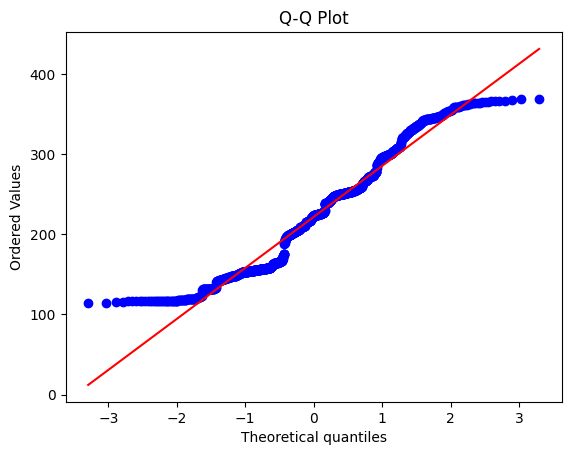

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Sample Data
data_series = df_can_groceries["VALUE"]

# Calculate Mean & Median
mean_val = np.mean(data_series)
median_val = np.median(data_series)

print(f"Mean: {mean_val}, Median: {median_val}")

# Check Skewness & Kurtosis
skewness = stats.skew(data_series)
kurtosis = stats.kurtosis(data_series) + 3  # Adjusted for normal distribution

print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")

# Q-Q Plot
stats.probplot(data_series, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()


Shapiro-Wilk Test: Statistic=0.9601010452675659, p-value=3.582439734931501e-19
Anderson-Darling Test: Statistic=15.83648639168905, Critical Values=[0.574 0.654 0.785 0.915 1.089]


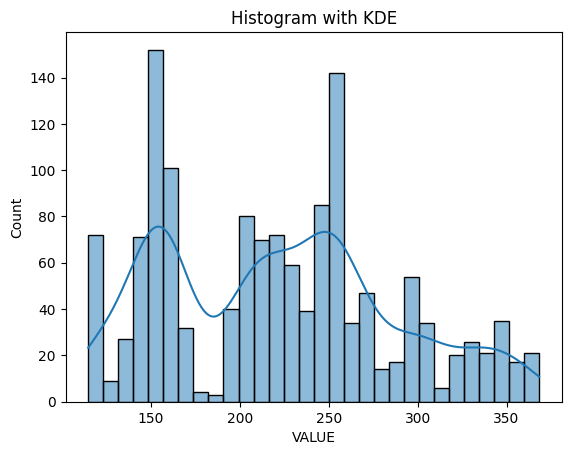

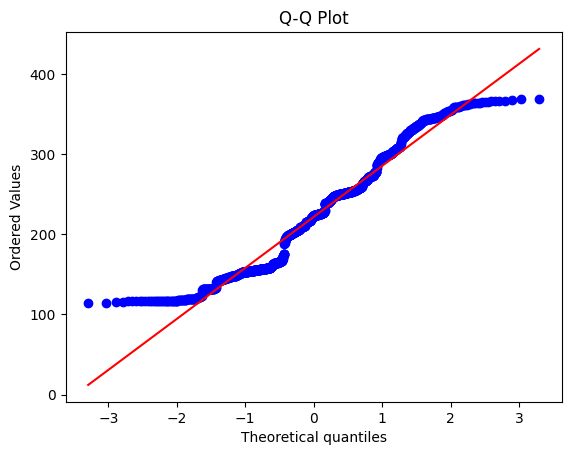

In [46]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Sample Data (Replace with actual dataset)
data_series = df_can_groceries["VALUE"]

# Normality Tests
shapiro_test = stats.shapiro(data_series)
anderson_test = stats.anderson(data_series, dist="norm")

print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
print(f"Anderson-Darling Test: Statistic={anderson_test.statistic}, Critical Values={anderson_test.critical_values}")

# Histogram
sns.histplot(data_series, kde=True, bins=30)
plt.title("Histogram with KDE")
plt.show()

# Q-Q Plot
stats.probplot(data_series, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()
